In [1]:
import torch

In [2]:
saved_gate_path = ["/home/wjbang/workspace/pMoE/pMoE/gate_data/enwik8_1000_20250115-213836.pt",
                   "/home/wjbang/workspace/pMoE/pMoE/gate_data/wikitext-2_1000_20250116-125819.pt",
                   "/home/wjbang/workspace/pMoE/pMoE/gate_data/squad_1000_20250116-142453.pt"]

In [24]:
def get_statistical_data(saved_gate_path, bsz=4):
    '''
    Figure out the most imbalanced token distribution on each dataset
    Only compatible with the moe models with 64 experts
    '''
    final_record = []
    
    for path in saved_gate_path:
        dataset_stat = []
        gate_data = torch.load(path)
        num_iters = len(gate_data)
        num_layers = len(gate_data[0])-2
        for layer_idx in range(1, num_layers+1):
            for start_id in range(0, num_iters, bsz):
                batch = []
                end_id = max(start_id+bsz, num_iters)
                for element in range(start_id, end_id):
                    batch.append(gate_data[element][f"layer_{layer_idx}_gate"])
                batch = torch.cat(batch, dim=0)
                batch = batch.reshape(1, -1).squeeze(0)
                batch = batch // 8
                counts = torch.bincount(batch, minlength=8)
                imbalance_level = counts.max() / counts.sum()
                stat_item = {
                    "stat": counts,
                    "imbalance": imbalance_level,
                    "layer_idx": layer_idx,
                    "batch_num": start_id,
                    "batch_size": bsz
                }
                dataset_stat.append(stat_item)
                
        max_imbalance = -1
        max_imbalance_item = None
        for item in dataset_stat:
            if item["imbalance"] > max_imbalance:
                max_imbalance = item["imbalance"]
                max_imbalance_item = item
        final_record.append(max_imbalance_item)
        
    return final_record

In [25]:
final_record = get_statistical_data(saved_gate_path)

/tmp/ipykernel_3771657/3702998072.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gate_data = torch.load(path)


In [26]:
print(final_record[0])
print(final_record[1])
print(final_record[2])

{'stat': tensor([ 3,  4,  1, 35,  4,  8, 10,  7], device='cuda:0'), 'imbalance': tensor(0.4861, device='cuda:0'), 'layer_idx': 11, 'batch_num': 996, 'batch_size': 4}
{'stat': tensor([ 2122,  4949,  3425, 15771,  2352,  4292,  4337,  7234],
       device='cuda:0'), 'imbalance': tensor(0.3545, device='cuda:0'), 'layer_idx': 11, 'batch_num': 824, 'batch_size': 4}
{'stat': tensor([10, 44, 18, 15, 10, 10,  9,  8], device='cuda:0'), 'imbalance': tensor(0.3548, device='cuda:0'), 'layer_idx': 7, 'batch_num': 996, 'batch_size': 4}


In [27]:
import matplotlib.pyplot as plt

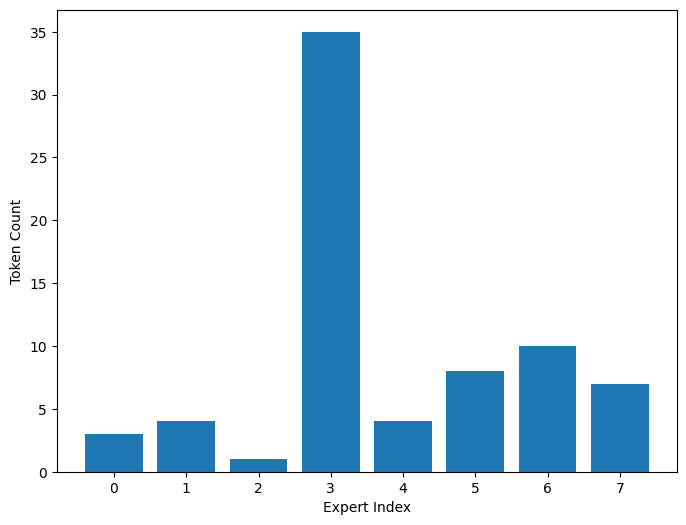

In [28]:
# enwik8
token_count = final_record[0]["stat"].cpu()
expert_idx = range(len(token_count))

plt.figure(figsize=(8, 6))
plt.bar(expert_idx, token_count)    
plt.title("")
plt.xlabel("Expert Index")
plt.ylabel("Token Count")
plt.xticks(expert_idx)

plt.show()

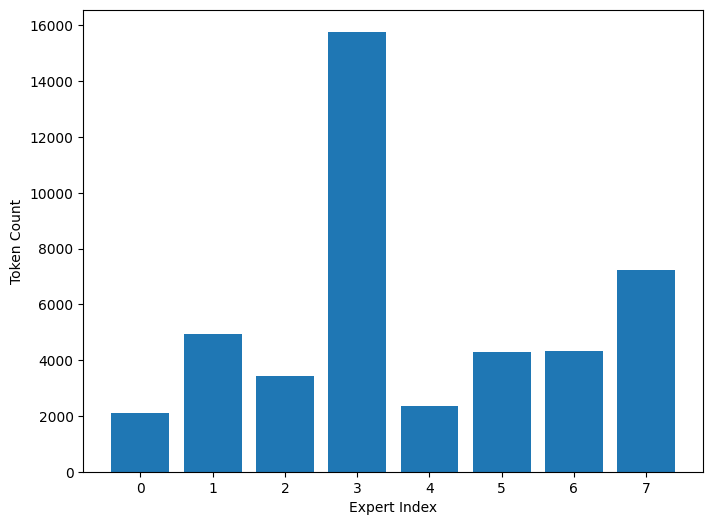

In [29]:
# wikitext-2
token_count = final_record[1]["stat"].cpu()
expert_idx = range(len(token_count))

plt.figure(figsize=(8, 6))
plt.bar(expert_idx, token_count)    
plt.title("")
plt.xlabel("Expert Index")
plt.ylabel("Token Count")
plt.xticks(expert_idx)

plt.show()

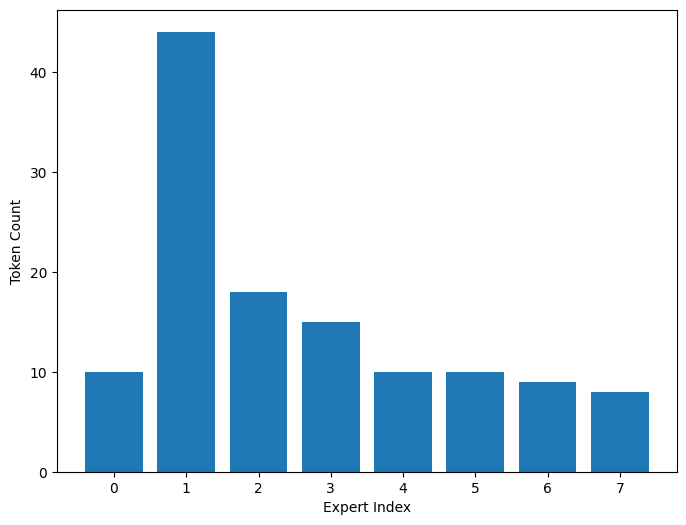

In [30]:
# SQUAD: question
token_count = final_record[2]["stat"].cpu()
expert_idx = range(len(token_count))

plt.figure(figsize=(8, 6))
plt.bar(expert_idx, token_count)    
plt.title("")
plt.xlabel("Expert Index")
plt.ylabel("Token Count")
plt.xticks(expert_idx)

plt.show()

In [21]:
def get_hardcoded_gate_data(saved_gate_path):
    '''
    Get the hardcoded gate data
    Only compatible with the deepseek-ai/deepseek-moe-16b-base model
    '''
    final_record = []
    for path in saved_gate_path:
        gate_data = torch.load(path)
        num_iters = len(gate_data)
        num_layers = len(gate_data[0])-2
        hardcode_list = []
        for i in range(num_iters):
            item = {}
            item[0] = torch.randint(0, 8, (gate_data[i][f'layer_1_gate'].shape[0],))
            for layer_idx in range(1, num_layers+1):
                item[layer_idx] = gate_data[i][f'layer_{layer_idx}_gate'][:, 0] // 8 # top-1 idx
            hardcode_list.append(item)
        final_record.append(hardcode_list)
    
    return final_record

In [22]:
hardcoded_gate_data = get_hardcoded_gate_data(saved_gate_path)

/tmp/ipykernel_3771657/1096947229.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gate_data = torch.load(path)


In [32]:
# Save the data
import os
torch.save(hardcoded_gate_data, os.path.join("/home/wjbang/workspace/pMoE/pMoE/gate_data/analysis_results","hardcoded_gate_data.pt"))
torch.save(final_record, os.path.join("/home/wjbang/workspace/pMoE/pMoE/gate_data/analysis_results","statistical_data.pt"))